In [143]:
#--------------------------------------------------------------#
#### Market Analysis in Banking Domain by PySpark ####
#--------------------------------------------------------------#
## import libraies and define utility methods 
from collections import namedtuple
import csv 
from io import StringIO

from pyspark.sql import SQLContext

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
from pyspark.sql.types import StringType

sqlContext = SQLContext(sc)
fields   = 'age job marital education default balance housing loan contact month day_of_week duration campaign pdays  previous poutcome y'

Bank = namedtuple('Bank', fields)

def notHeader(row):
    return "age" not in row

def parse(row):
    row[0]  = int(row[0])
    row[5]  = int(row[5])
    row[11]  = int(row[11])
    row[12]  = int(row[12])
    row[14]  = int(row[14])
    return Bank(*row[:17])

def split(line):
    reader = csv.reader(StringIO(line))
    return next(reader)

In [144]:
#1.	Load data and create a Spark data frame
lines= sc.textFile("C:\\Users\\HOME\\Downloads\\Project 1_dataset_bank.csv")
parsed=lines.map(lambda x: x.replace("\"","")).filter(notHeader).map(lambda x: x.split(';')).map(parse)
parsed.take(2)



[Bank(age=44, job='technician', marital='single', education='secondary', default='no', balance=29, housing='yes', loan='no', contact='unknown', month='5', day_of_week='may', duration=151, campaign=1, pdays='-1', previous=0, poutcome='unknown', y='no'),
 Bank(age=33, job='entrepreneur', marital='married', education='secondary', default='no', balance=2, housing='yes', loan='yes', contact='unknown', month='5', day_of_week='may', duration=76, campaign=1, pdays='-1', previous=0, poutcome='unknown', y='no')]

In [145]:
#Register temptabale 
schemaBank = sqlContext.createDataFrame(parsed)
schemaBank.registerTempTable("bank")


In [146]:
#2.	Give marketing success rate (No. of people subscribed / total no. of entries)   
subscribed = sqlContext.sql("select count(*) from bank where y='yes'").collect()[0][0]

total = sqlContext.sql("select count(*) from bank ").collect()[0][0]
successRate = (subscribed/total)*100
successRate
print("Success Rate: {:.2f}%".format(successRate))

Success Rate: 11.15%


In [147]:
#2.	Give marketing non success rate (No. of people non subscribed / total no. of entries)   
notsubscribed = sqlContext.sql("select count(*) from bank where y!='yes'").collect()[0][0]
notsubscribedRate= (notsubscribed/total)*100
print("Not SubscribedRate Rate: {:.2f}%".format(notsubscribedRate))


Not SubscribedRate Rate: 88.85%


In [148]:
#1.	Give the maximum, mean, and minimum age of the average targeted customer
max_age = sqlContext.sql("select max(age) from bank").collect()[0][0]
min_age = sqlContext.sql("select min(age) from bank").collect()[0][0]
avg_age = sqlContext.sql("select avg(age) from bank").collect()[0][0]

print("Max Age : {} Years , Min Age : {} Years , Avg_Age :{:.0f} Years".format(max_age,min_age,avg_age))

Max Age : 95 Years , Min Age : 18 Years , Avg_Age :41 Years


In [149]:
#2.	Check the quality of customers by checking average balance, median balance of customers
avg_balance = sqlContext.sql("select avg(balance)  from bank").collect()[0][0]
median_balance = sqlContext.sql("select percentile(balance,0.5) from bank").collect()[0][0]
print("Average Balance :{:.2f} , Median Balance {:.2f}".format(avg_balance,median_balance))

Average Balance :1256.10 , Median Balance 420.00


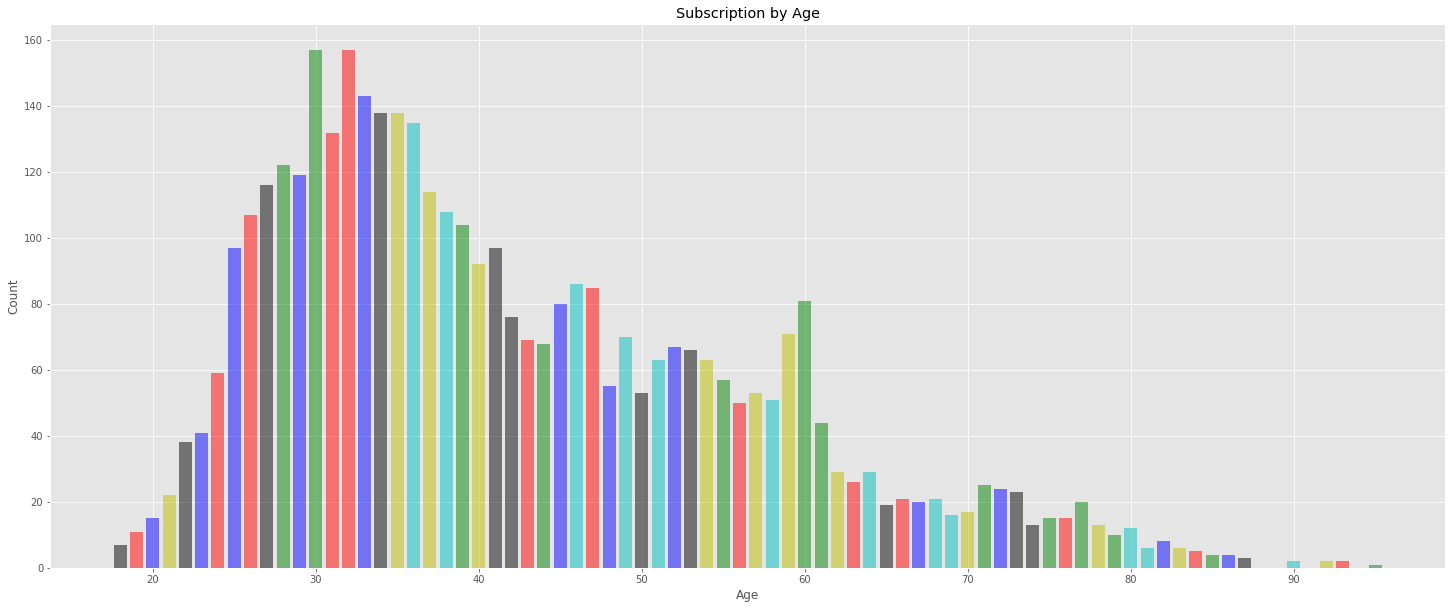

In [150]:
#3.	Check if age matters in marketing subscription for deposit
agewise_sub= sqlContext.sql("select age, count(*) as count from bank where y='yes' group by age order by count desc ")
pddf = agewise_sub.toPandas()
ax =plt.figure(figsize=(25,10))
plt.bar(pddf['age'], pddf['count'], align='center', alpha=0.5, color='rgbkyc')
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Subscription by Age')

plt.show()
# Age 30-36 peoplare are subscribed most

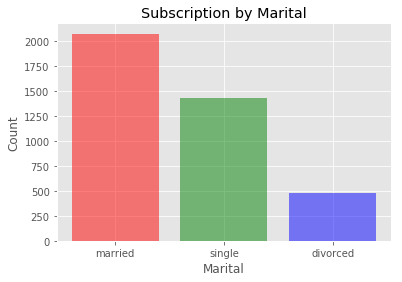

In [151]:
#4.	Check if marital status mattered for a subscription to deposit
marital_sub= sqlContext.sql("select marital, count(*) as count from bank where y='yes' group by marital order by count desc ")
mdf = marital_sub.toPandas()
x_pos = np.arange(len(mdf['marital']))
plt.bar(x_pos, mdf['count'], align='center', alpha=0.5, color='rgb')
plt.xticks(x_pos, mdf['marital'])
plt.ylabel('Count')
plt.xlabel('Marital')
plt.title('Subscription by Marital')

plt.show()

## married people are subscriped most

In [180]:
#5.	Check if age and marital status together mattered for a subscription to deposit scheme
both_sub= sqlContext.sql("select marital,age, count(*) as count from bank where y='yes' group by marital,age order by count desc ")
bdf = both_sub.toPandas()
#bdf.head(20)
bdf.set_index(['marital', 'age'], inplace=True)

bdf.head(20)

## Single and age 25-30 shows more subscried


count
marital age       
single  30     105
        28     102
        26      95
        29      92
        27      88
        25      88
married 34      84
single  32      83
married 35      71
single  31      70
married 33      69
        32      68
        47      67
        36      66
single  33      63
married 46      61
        37      61
        39      61
        60      60
        38      60

In [133]:
#6.	Do feature engineering for the bank and find the right age effect on the campaign.


def groupAge(age):
    group="";
    if (age < 20):
        group="Teen"
    elif (age > 20 and age <= 32):
        group="Young"
    elif (age > 33 and age <= 55):
        group="Middle Aged"
    else:
        group="Old"
    return group

from pyspark.sql.types import StringType
sqlContext.registerFunction("ageRDD", lambda x: groupAge(x), StringType())
#sqlContext.sql("SELECT ageRDD(52)").collect()

new_agewise_sub= sqlContext.sql("select ageRDD(age) as new_age, * from bank where y='yes' ")
new_agewise_sub.registerTempTable("bank_new")


new_agewise_df= sqlContext.sql("select new_age, count(*) as count from bank_new where y='yes' group by new_age order by count desc ")
nbdf = new_agewise_df.toPandas()
nbdf.head(5)

#  Middle-Aged pepople are more subscriped

,new_age,count
0,Middle Aged,1884
1,Young,1167
2,Old,919
3,Teen,18


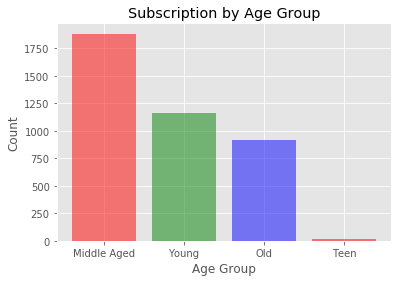

In [134]:
# View by bar chart
x_pos = np.arange(len(nbdf['new_age']))
plt.bar(x_pos, nbdf['count'], align='center', alpha=0.5, color='rgb')
plt.xticks(x_pos, nbdf['new_age'])
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.title('Subscription by Age Group')

plt.show()

#   Middle-Aged pepople are more subscriped.So we need to target Middle aged people  

In [142]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="new_age", outputCol="ageIndex")
model = indexer.fit(new_agewise_sub)
model.transform(new_agewise_sub).select("new_age","ageIndex").show(20)
#  Middle-Aged pepople are more frequent 

+-----------+--------+
|    new_age|ageIndex|
+-----------+--------+
|        Old|     2.0|
|        Old|     2.0|
|Middle Aged|     0.0|
|Middle Aged|     0.0|
|Middle Aged|     0.0|
|        Old|     2.0|
|Middle Aged|     0.0|
|Middle Aged|     0.0|
|Middle Aged|     0.0|
|Middle Aged|     0.0|
|      Young|     1.0|
|      Young|     1.0|
|Middle Aged|     0.0|
|Middle Aged|     0.0|
|Middle Aged|     0.0|
|Middle Aged|     0.0|
|Middle Aged|     0.0|
|      Young|     1.0|
|Middle Aged|     0.0|
|      Young|     1.0|
+-----------+--------+
only showing top 20 rows

